Загрузка библиотек

In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import io, color, exposure
from glob import glob
import os
from sklearn.decomposition import PCA
from numba import jit, prange
import cv2

# Подготовка данных

DoG-фильтр (Difference of Gaussians).
Моделирование рецептивных полей ганглиозных клеток сетчатки (ON/OFF клетки)

In [2]:
def create_dog_filter(sigma_center=1.0, sigma_surround=2.0, k=0.3, size=None):
    size = int(6 * sigma_surround) + 1
    if size % 2 == 0:
        size += 1

    x = np.arange(-size//2, size//2 + 1)
    y = np.arange(-size//2, size//2 + 1)
    xx, yy = np.meshgrid(x, y)

    # Центральный гауссиан (возбуждающий)
    center = np.exp(-(xx**2 + yy**2) / (2 * sigma_center**2))

    # Периферийный гауссиан (тормозящий)
    surround = np.exp(-(xx**2 + yy**2) / (2 * sigma_surround**2))

    # DoG = центр - k * периферия
    dog = center - k * surround

    # Нормализация фильтра
    dog -= np.mean(dog)
    dog /= np.max(np.abs(dog))

    return dog

Загрузка и преобработка изображений природы

In [3]:
def load_and_process_image(image_path):
    # Загружаем изображение и переводим его в чёрно-белый формат
    image = io.imread(image_path)
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    # Улучшаем контраст изображения
    image = exposure.equalize_adapthist(image, clip_limit=0.03)

    # Создаем DoG-фильтр
    dog_filter = create_dog_filter(sigma_center=1.0, sigma_surround=2.0, k=0.3)

    # Применяем фильтр к изображению
    response = ndimage.convolve(image, dog_filter, mode='reflect')

    # Разделение ON/OFF каналов
    on_activity = np.maximum(0, response)
    off_activity = np.maximum(0, -response)

    return image, on_activity, off_activity, response

Извлечение патчей из ON/OFF активностей

In [4]:
def extract_patches(on_activity, off_activity, num_patches, patch_size):
    h, w = on_activity.shape
    patches = []

    for _ in range(num_patches):
        i = np.random.randint(0, h - patch_size)
        j = np.random.randint(0, w - patch_size)

        # Извлекаем патчи из ON и OFF каналов
        patch_on = on_activity[i:i+patch_size, j:j+patch_size]
        patch_off = off_activity[i:i+patch_size, j:j+patch_size]

        # Нормализуем каждый патч
        patch_on = (patch_on - np.mean(patch_on)) / (np.std(patch_on) + 1e-8)
        patch_off = (patch_off - np.mean(patch_off)) / (np.std(patch_off) + 1e-8)

        # Объединяем в один патч с двумя каналами
        patch = np.stack((patch_on, patch_off), axis=-1)
        patches.append(patch)

    return np.array(patches)

Визуализация результатов

In [5]:
def debug_visualization(image, on_activity, off_activity, response, image_name):
    plt.figure(figsize=(10, 18))

    # Исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Оригинальное изображение')
    plt.axis('off')

    # ON активность
    plt.subplot(1, 3, 2)
    plt.imshow(on_activity, cmap='Reds')
    plt.title('ON активность (светлые грани на тёмном)')
    plt.axis('off')

    # OFF активность
    plt.subplot(1, 3, 3)
    plt.imshow(off_activity, cmap='Blues')
    plt.title('OFF активность (тёмные грани на светлом)')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'results/debug_{image_name}.png')
    plt.show()

    # Статистика
    print(f"\n{'='*50}")
    print(f"Изображение: {image_name}")
    print(f"{'='*50}")
    print(f"ON активность: {np.count_nonzero(on_activity)} активных пикселей из {on_activity.size}")
    print(f"OFF активность: {np.count_nonzero(off_activity)} активных пикселей из {off_activity.size}")
    print(f"Корреляция ON-OFF: {np.corrcoef(on_activity.ravel(), off_activity.ravel())[0,1]:.4f}")
    print(f"Соотношение активных пикселей ON/OFF: {np.count_nonzero(on_activity)/max(1, np.count_nonzero(off_activity)):.2f}")

def visualize_patches(patches, patch_size, image_name):
    plt.figure(figsize=(12, 6))

    # ON патчи
    plt.subplot(1, 2, 1)
    mosaic_on = np.zeros((patch_size*4, patch_size*4))
    for idx in range(16):
        i = (idx // 4) * patch_size
        j = (idx % 4) * patch_size
        mosaic_on[i:i+patch_size, j:j+patch_size] = patches[idx, :, :, 0]
    plt.imshow(mosaic_on, cmap='Reds')
    plt.title('ON патчи')
    plt.axis('off')

    # OFF патчи
    plt.subplot(1, 2, 2)
    mosaic_off = np.zeros((patch_size*4, patch_size*4))
    for idx in range(16):
        i = (idx // 4) * patch_size
        j = (idx % 4) * patch_size
        mosaic_off[i:i+patch_size, j:j+patch_size] = patches[idx, :, :, 1]
    plt.imshow(mosaic_off, cmap='Blues')
    plt.title('OFF патчи')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'results/patches_{image_name}.png')
    plt.show()


Формирование патчей из изображений природы (основной код)

Найдено 35 изображений в директории pic_nat

Обработка изображения 1/35


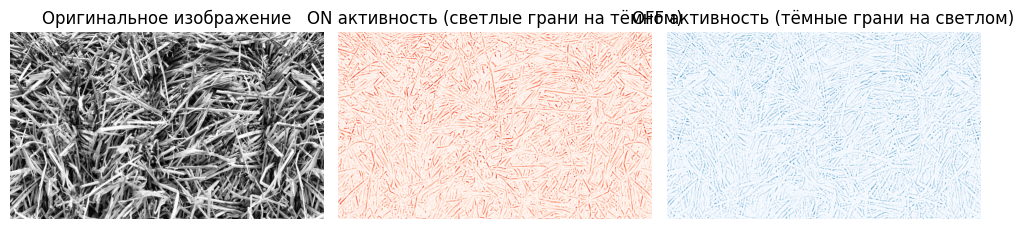


СТАТИСТИКА ДЛЯ ИЗОБРАЖЕНИЯ: nature_image (23)
ON активность: 213565 активных пикселей из 420000
OFF активность: 206435 активных пикселей из 420000
Корреляция ON-OFF: -0.4365
Соотношение активных пикселей ON/OFF: 1.03
Корреляция ON с инвертированным OFF: 0.4365


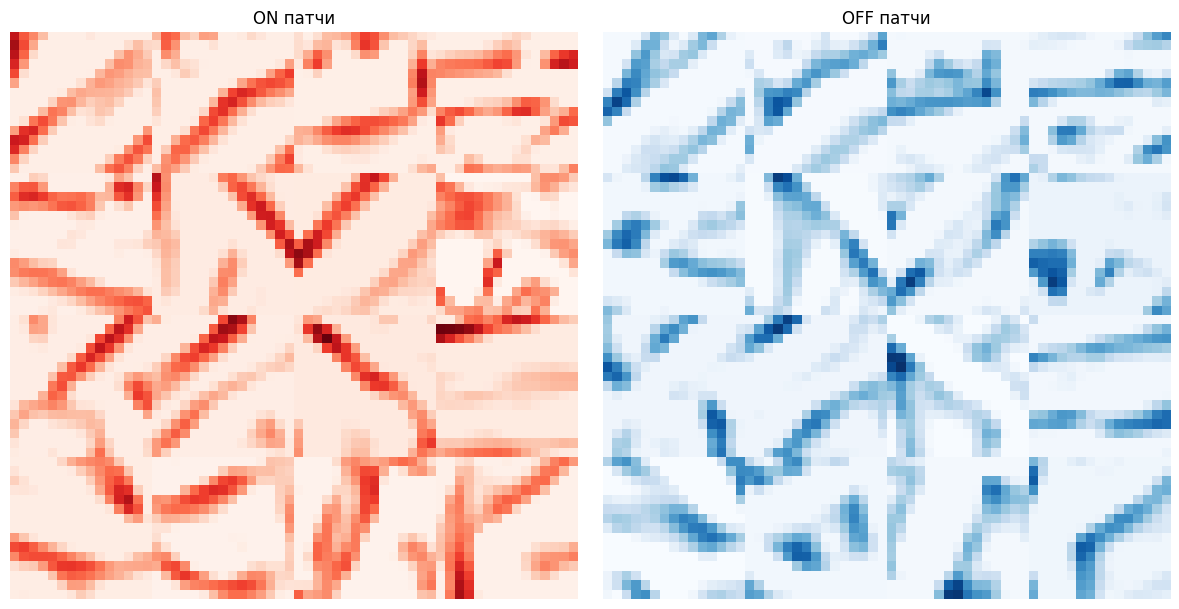


Обработка изображения 2/35


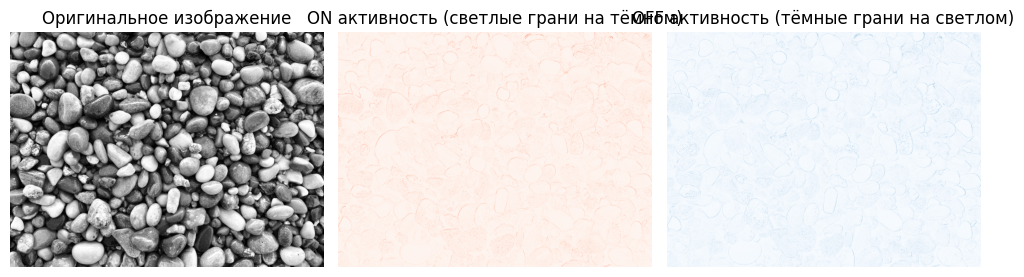


СТАТИСТИКА ДЛЯ ИЗОБРАЖЕНИЯ: nature_image (5)
ON активность: 2836031 активных пикселей из 5658820
OFF активность: 2822789 активных пикселей из 5658820
Корреляция ON-OFF: -0.2873
Соотношение активных пикселей ON/OFF: 1.00
Корреляция ON с инвертированным OFF: 0.2873

Обработка изображения 3/35


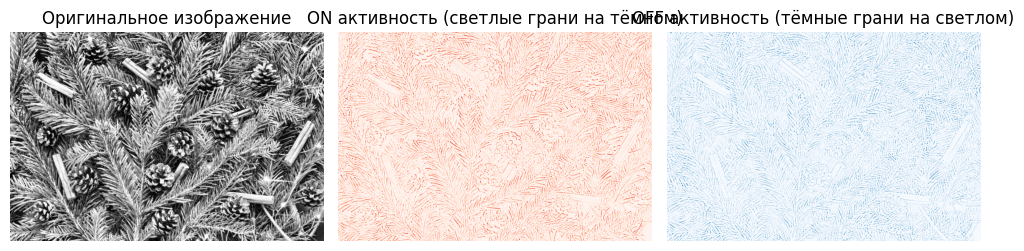


СТАТИСТИКА ДЛЯ ИЗОБРАЖЕНИЯ: nature_image (11)
ON активность: 379443 активных пикселей из 761484
OFF активность: 382041 активных пикселей из 761484
Корреляция ON-OFF: -0.4460
Соотношение активных пикселей ON/OFF: 0.99
Корреляция ON с инвертированным OFF: 0.4460

Обработка изображения 4/35

Обработка изображения 5/35

Обработка изображения 6/35

Обработка изображения 7/35

Обработка изображения 8/35

Обработка изображения 9/35

Обработка изображения 10/35

Обработка изображения 11/35

Обработка изображения 12/35

Обработка изображения 13/35

Обработка изображения 14/35

Обработка изображения 15/35

Обработка изображения 16/35

Обработка изображения 17/35

Обработка изображения 18/35

Обработка изображения 19/35

Обработка изображения 20/35

Обработка изображения 21/35

Обработка изображения 22/35

Обработка изображения 23/35

Обработка изображения 24/35

Обработка изображения 25/35

Обработка изображения 26/35

Обработка изображения 27/35

Обработка изображения 28/35

Обработка изображе

In [6]:
# Параметры
patch_size = 15
num_patches_per_image = 1000
all_patches = []


# Создаем директорию для результатов, если ее нет
os.makedirs('results', exist_ok=True)
# Получаем список файлов
image_dir = 'images_of_nature'
fnames = glob(os.path.join(image_dir, '*'))
file_number = len(fnames)

print(f"Найдено {file_number} изображений в директории {image_dir}")

for idx, image_path in enumerate(fnames):
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    print(f"\nОбработка изображения {idx+1}/{file_number}")

    # Загружаем и обрабатываем изображение
    image, on_activity, off_activity, response = load_and_process_image(image_path)

    # Отладочная визуализация для первых 3 изображений
    if idx < 3:
        debug_visualization(image, on_activity, off_activity, response, image_name)

    # Извлекаем патчи
    patches = extract_patches(on_activity, off_activity, num_patches_per_image, patch_size)
    all_patches.append(patches)

    # Визуализация патчей для первого изображения
    if idx == 0:
        visualize_patches(patches, patch_size, image_name)

# Объединяем все патчи
all_patches_combined = np.concatenate(all_patches, axis=0)

# Сохраняем объединенные патчи
np.save('results/all_patches.npy', all_patches_combined)

# Обучение с топографией

Обучение

In [7]:
@jit(nopython=True)
def euclidean_distance(x, y):
    """Вычисление евклидова расстояния между двумя точками"""
    return np.sqrt(np.sum((x - y)**2))

@jit(nopython=True)
def compute_all_distances(neuron_coords):
    """Вычисление всех расстояний между нейронами"""
    n_neurons = neuron_coords.shape[0]
    distances = np.zeros((n_neurons, n_neurons))

    for i in range(n_neurons):
        for j in range(n_neurons):
            distances[i,j] = euclidean_distance(neuron_coords[i], neuron_coords[j])

    return distances

@jit(nopython=True, parallel=True)
def normalize_weights(weights):
    """Нормализация весов"""
    n_neurons = weights.shape[0]

    for i in prange(n_neurons):
        norm = np.sqrt(np.sum(weights[i]**2))

        if norm > 0:
            weights[i] /= norm
        elif norm <= 0:
            # Инициализация случайными значениями, если норма нулевая
            weights[i] = np.random.randn(weights.shape[1]) * 0.01


    return weights

@jit(nopython=True, fastmath=False)
def update_weights_oja(weights, x, winner_indices, distances, current_lr, current_sigma, activations):
    """Обновление весов по правилу Oja с учетом соседства"""
    n_neurons = weights.shape[0]
    for winner_idx in winner_indices:
      for j in range(n_neurons):
          distance = distances[winner_idx, j]
          neighborhood = np.exp(-distance**2 / (2 * current_sigma**2))

          if neighborhood > 0.01:  # Обновляем только значимых соседей
              y = activations[j]  # Активация j-го нейрона

              # Правило Oja с защитой от переполнения
              y_squared = y * y
              if y_squared < 1e6:  # Защита от больших значений
                  delta = current_lr * neighborhood * (y * x - y_squared * weights[j])

                  # Ограничение размера шага
                  max_delta = 0.1 * np.abs(weights[j]) + 1e-8
                  delta = np.sign(delta) * np.minimum(np.abs(delta), max_delta)

                  weights[j] += delta


    return weights

def train_v1_with_topology(patches, grid_size=(8, 8), initial_lr=0.01, n_epochs=100,
                          initial_sigma=3.0, final_sigma=0.5, k_winners=5):
    """Обучение V1 с топографической организацией и k-WTA торможением"""
    n_neurons = grid_size[0] * grid_size[1]
    n_samples, patch_size, _, n_channels = patches.shape
    input_dim = patch_size * patch_size * n_channels

    # Инициализация весов
    weights = np.random.randn(n_neurons, input_dim) * 0.1
    weights = normalize_weights(weights)

    # Преобразуем патчи
    patches_flat = patches.reshape(n_samples, -1)

    # Координаты нейронов в сетке
    neuron_coords = np.array([(i, j) for i in range(grid_size[0]) for j in range(grid_size[1])])
    # Предвычисление расстояний
    distances_matrix = compute_all_distances(neuron_coords)

    print(f"Обучение топографической сети V1: {n_neurons} нейронов, {n_samples} патчей")
    print(f"k-WTA параметр: {k_winners} победителей")

    for epoch in range(n_epochs):
        # Экспоненциальное уменьшение параметров
        current_sigma = initial_sigma * (final_sigma / initial_sigma) ** (epoch / n_epochs)
        current_lr = initial_lr * np.exp(-epoch / (n_epochs / 3))

        # Перемешиваем данные
        indices = np.random.permutation(n_samples)

        for i in indices:
            x = patches_flat[i]

            # Вычисляем активации
            activations = np.dot(weights, x)

            # Определяем самые активные нейроны
            winner_indices = np.argsort(activations)[-k_winners:]

            # Обучаем веса тольео самых активных нейронов
            weights = update_weights_oja(weights, x, winner_indices, distances_matrix,
                                    current_lr, current_sigma, activations)

            # Периодическая нормализация
            if i % 100 == 0:
                weights = normalize_weights(weights)
        if epoch % 20 == 0:
            print(f"Эпоха {epoch}/{n_epochs}, σ: {current_sigma:.2f}, lr: {current_lr:.6f}")

    # Финальная нормализация
    weights = normalize_weights(weights)

    return weights, neuron_coords, distances_matrix

Визуализация

In [8]:
def visualize_topographic_rf(weights, neuron_coords, grid_size, patch_size, n_channels=2):
    """Визуализация рецептивных полей с топографической организацией"""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))

    for i in range(len(weights)):
        row, col = neuron_coords[i]

        # Восстанавливаем РП
        rf = weights[i].reshape(patch_size, patch_size, n_channels)
        rf_diff = rf[:, :, 0] - rf[:, :, 1]

        axes[row, col].imshow(rf_diff, cmap='RdBu', vmin=-0.5, vmax=0.5)
        axes[row, col].set_title(f'({row},{col})', fontsize=8)
        axes[row, col].axis('off')

    plt.suptitle('Топографическая карта рецептивных полей V1', fontsize=16)
    plt.tight_layout()
    plt.savefig('results/topographic_rf_kwta.png', dpi=150)
    plt.show()


Основной код

Загружено патчей: (35000, 15, 15, 2)
Обучение топографической сети V1: 81 нейронов, 35000 патчей
k-WTA параметр: 1 победителей
Эпоха 0/100, σ: 4.00, lr: 0.005000
Эпоха 20/100, σ: 2.64, lr: 0.002744
Эпоха 40/100, σ: 1.74, lr: 0.001506
Эпоха 60/100, σ: 1.15, lr: 0.000826
Эпоха 80/100, σ: 0.76, lr: 0.000454


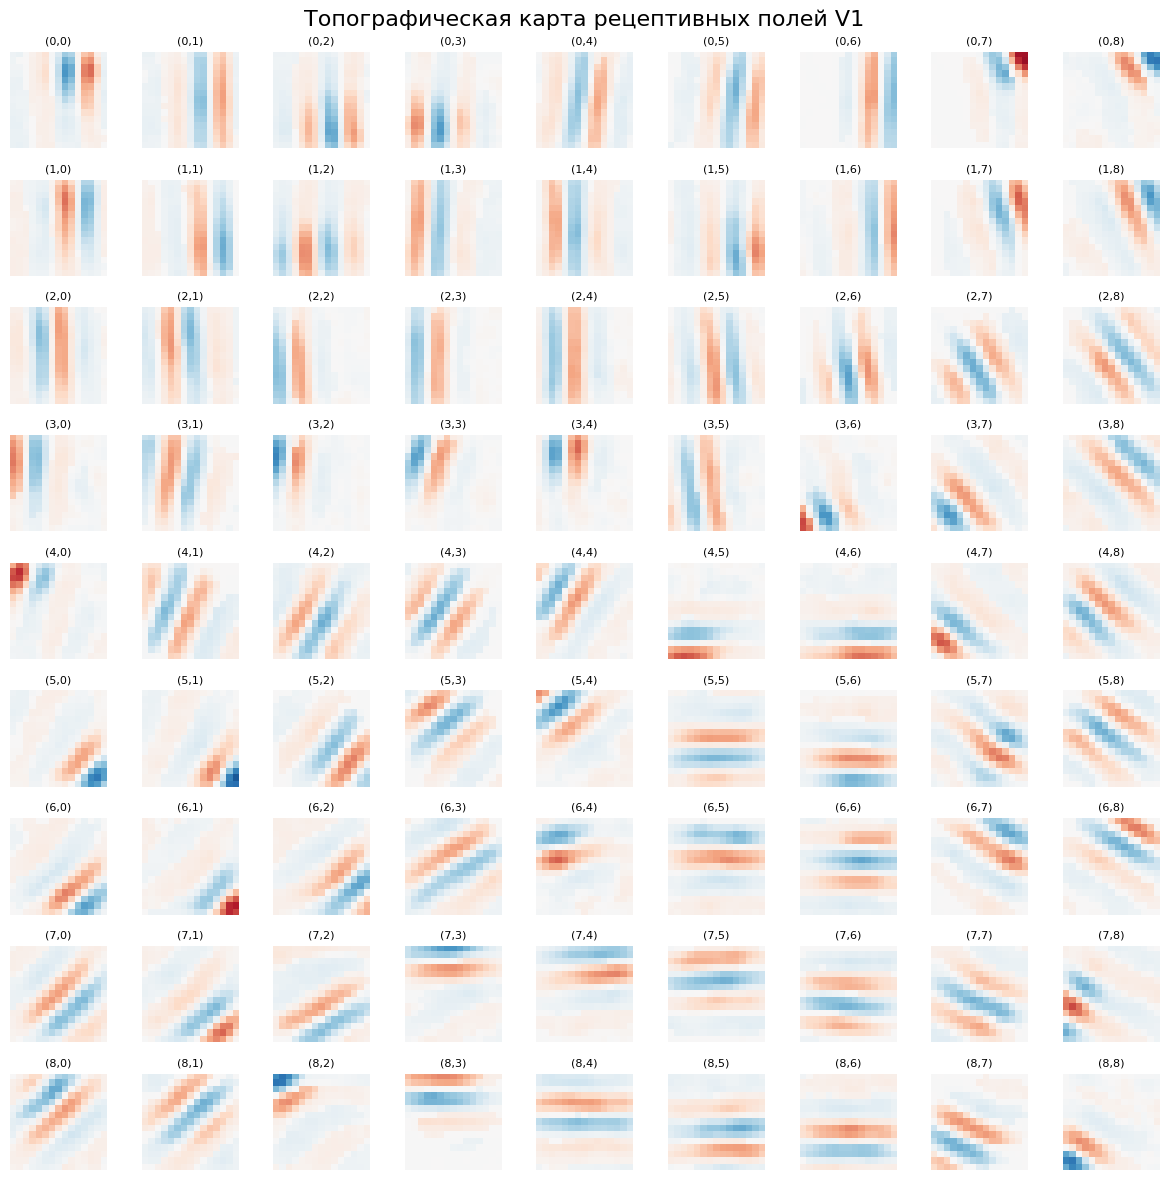

In [14]:
# Загружаем патчи
all_patches = np.load('results/all_patches.npy')
print(f"Загружено патчей: {all_patches.shape}")

# Параметры обучения
grid_size = (9, 9)
patch_size = all_patches.shape[1]
n_channels = all_patches.shape[3]

# Обучаем сеть
weights, neuron_coords, distances_matrix = train_v1_with_topology(
    all_patches,
    grid_size=grid_size,
    initial_lr=0.005,
    n_epochs=100,
    initial_sigma=4.0,
    final_sigma=0.5,
    k_winners=1
)

# Визуализация
visualize_topographic_rf(weights, neuron_coords, grid_size, patch_size, n_channels)



# Анализ ориентации

Габоровский фильтр и индекс ориентационной селективности

In [10]:
def create_gabor_bank(orientations, ksize=15, sigma=4., lambd=8., gamma=0.5):
    # Рассматрриваем два фильтра с фазами сдвинутами на 90 для обеспечения инвариантности к положению края на рецептивном поле
    kernels_even = []
    kernels_odd = []
    for theta in orientations:
        # Преобразование градусов в радианы
        theta_rad = np.deg2rad(theta)
        # Создание ядра Габора
        kernel_even = cv2.getGaborKernel((ksize, ksize), sigma, theta_rad, lambd, gamma, 0, ktype=cv2.CV_32F)
        kernel_odd = cv2.getGaborKernel((ksize, ksize), sigma, theta_rad, lambd, gamma, 90, ktype=cv2.CV_32F)
        kernels_even.append(kernel_even)
        kernels_odd.append(kernel_odd)
    return kernels_even, kernels_odd

def compute_orientation_responses(weight_maps, kernels_even, kernels_odd, orientations):
    n_neurons = weight_maps.shape[0]
    n_orientations = len(orientations)
    best_orientation = np.zeros(n_neurons)
    selectivity_index = np.zeros(n_neurons)

    for i in range(n_neurons):
        # Берем карту весов i-го нейрона и преобразуем в 2D
        w = weight_maps[i].reshape(patch_size, patch_size)
        # Нормализуем карту весов
        w_normalized = (w - w.mean()) / (w.std() + 1e-8)

        max_response = -np.inf
        best_idx = 0
        orientation_responses = []

        # Проверяем отклик на каждый фильтр
        for j in range(n_orientations):
            # Свертка с четным и нечетным фильтрами
            response_even = ndimage.convolve(w_normalized, kernels_even[j], mode='constant', cval=0.0)
            response_odd = ndimage.convolve(w_normalized, kernels_odd[j], mode='constant', cval=0.0)

            # Вычисление амплитуды отклика Габора (нормированная энергия) для инвариантности к положению линии
            energy = np.sqrt(np.mean(response_even**2 + response_odd**2))
            orientation_responses.append(energy)

        orientation_responses = np.array(orientation_responses)

        # Находим предпочитаемую ориентацию
        best_idx = np.argmax(orientation_responses)
        best_orientation[i] = orientations[best_idx]

        # Анализ селективности
        pref_angle = orientations[best_idx]
        ortho_angle = (pref_angle + 90) % 180
        ortho_response = orientation_responses[orientations == ortho_angle][0]
        selectivity_index[i] = (orientation_responses[best_idx] - ortho_response) / orientation_responses[best_idx]

    return best_orientation, selectivity_index

In [11]:

n_neurons = weights.shape[0]
weight_maps = weights.reshape(n_neurons, patch_size, patch_size, 2)

# Используем разность каналов ON и OFF для получения одноканального изображения
weight_maps_mono = weight_maps[:, :, :, 0] - weight_maps[:, :, :, 1]

# Создание фильтров (проверяем 18 ориентаций с шагом 10 градусов)
orientations_to_test = np.arange(0, 180, 10)
kernels_even, kernels_odd = create_gabor_bank(orientations_to_test, ksize=15, sigma=3.0, lambd=6.0)

# Вычисление ориентационных предпочтений интексов селективности
best_orientation, selectivity_index= compute_orientation_responses(weight_maps_mono, kernels_even, kernels_odd, orientations_to_test)


Визуализация ориентации

In [12]:
def visualize_combined_analysis(neuron_coords, orientations, grid_size):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Отображение ориентаций линиями
    line_length = 0.6

    for i, (y, x) in enumerate(neuron_coords):
        angle_rad = np.deg2rad(orientations[i])
        length = line_length

        dx = length * np.cos(angle_rad) / 2
        dy = length * np.sin(angle_rad) / 2

        ax1.plot([x - dx, x + dx], [y - dy, y + dy], 'k-', linewidth=2)

    ax1.set_xlim(-1, grid_size[1])
    ax1.set_ylim(-1, grid_size[0])
    ax1.set_aspect('equal')
    ax1.invert_yaxis()
    ax1.set_title('Визуализация линиями')
    ax1.set_xlabel('Позиция X')
    ax1.set_ylabel('Позиция Y')

    # Отображение ориентаций цветом
    orientation_norm = orientations / 180.0

    square_size = 1
    for i, (y, x) in enumerate(neuron_coords):
        hue = orientation_norm[i]
        color = plt.cm.hsv(hue)

        rect = plt.Rectangle((x - square_size/2, y - square_size/2),
                           square_size, square_size,
                           facecolor=color,
                           edgecolor='black', linewidth=0.5)
        ax2.add_patch(rect)

    ax2.set_xlim(-1, grid_size[1])
    ax2.set_ylim(-1, grid_size[0])
    ax2.set_aspect('equal')
    ax2.invert_yaxis()
    ax2.set_title('Визуализация цветом')
    ax2.set_xlabel('Позиция X')

    sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(0, 180))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, shrink=0.8)
    cbar.set_label('Ориентация (градусы)')

    plt.tight_layout()
    plt.show()

def plot_orientation_distribution(orientations):

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(orientations, bins=18, range=(0, 180), edgecolor='black', alpha=0.7)
    plt.xlabel('Ориентация (градусы)')
    plt.ylabel('Количество нейронов')
    plt.title('Распределение предпочитаемых ориентаций нейронов')
    plt.grid(True, alpha=0.3)
    plt.show()
def plot_selectivity_distribution(selectivity, bins=20):

    n, bins, patches = plt.hist(selectivity, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Индекс селективности')
    plt.ylabel('Количество нейронов')
    plt.title('Распределение селективности')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Добавляем статистику
    mean_sel = np.mean(selectivity)
    std_sel = np.std(selectivity)

    print(f"Общее количество нейронов: {len(selectivity)}")
    print(f"Средняя селективность: {mean_sel:.3f} ± {std_sel:.3f}")
    print(f"Медианная селективность: {np.median(selectivity):.3f}")



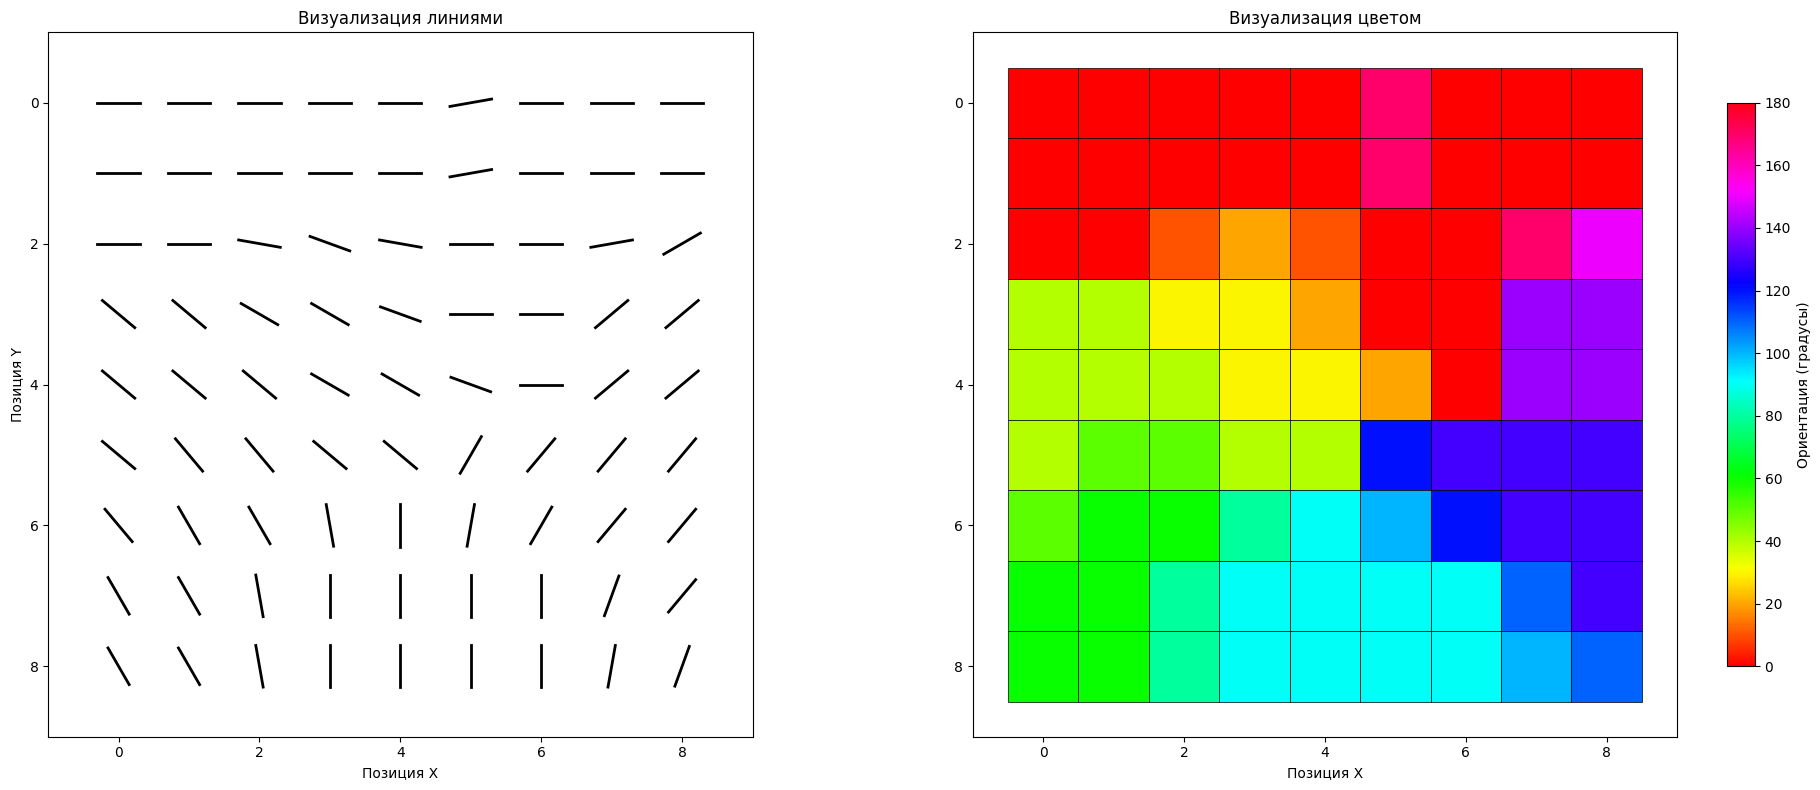

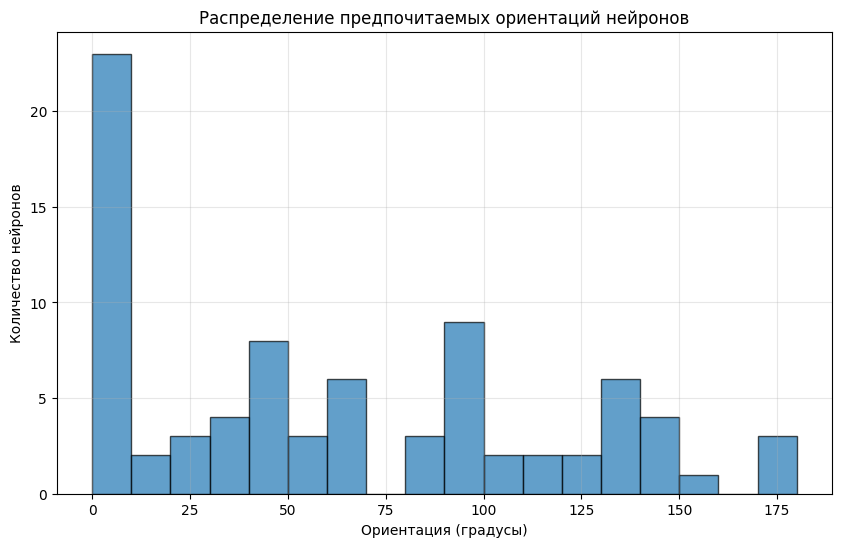

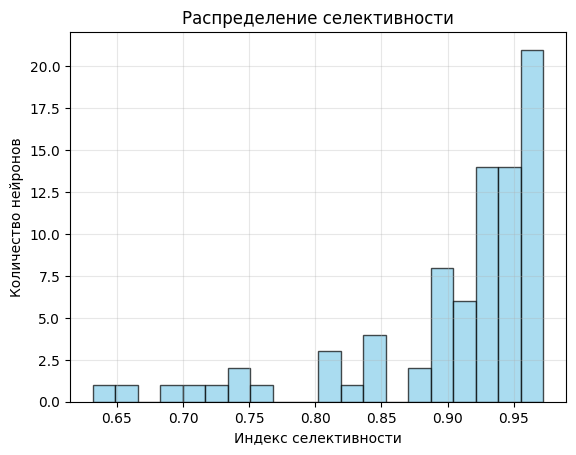

=== СТАТИСТИКА СЕЛЕКТИВНОСТИ ===
Общее количество нейронов: 81
Средняя селективность: 0.904 ± 0.077
Медианная селективность: 0.931


In [13]:
visualize_combined_analysis(neuron_coords, best_orientation,  grid_size=(9, 9))
plot_orientation_distribution(best_orientation)
plot_selectivity_distribution(selectivity_index, bins=20)
